# K-Fold CV for Boosting Methods Using SKLearn 

In [70]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd

In [71]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [73]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


In [74]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)

In [75]:
#df.head(5)
# df.info()
# df.describe()
#features_df_list[0]
counter = 0
testing_arr = []
training_arr = []
for subject in features_df_list:
    if counter != 22:
        training_arr.append(subject)
    else:
        testing_arr.append(subject)
    counter += 1
    
print(len(training_arr))
#type(df)

22


In [76]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn', 'Rhythm', 'Subject'],
      dtype='object')


# Extreme Gradient Boosting

1.5.1


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


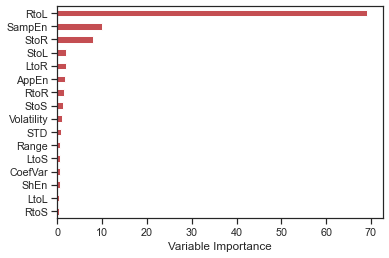

roc_auc_score 0.9771696447596725


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


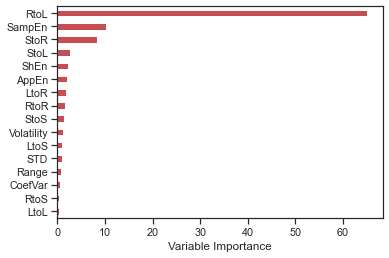

roc_auc_score 0.9863487462617897


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


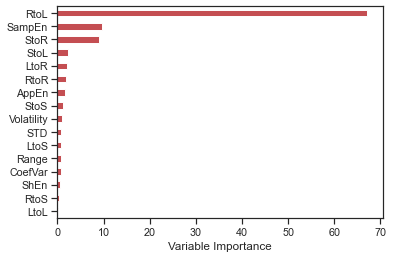

roc_auc_score 0.9991628090219641


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


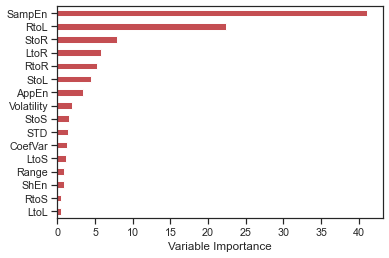

roc_auc_score 0.988601389882339


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


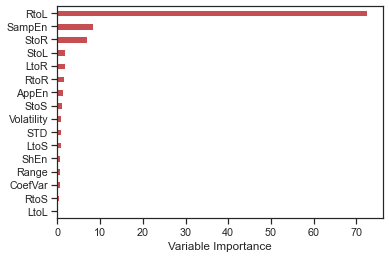

roc_auc_score 0.9999964224597975


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


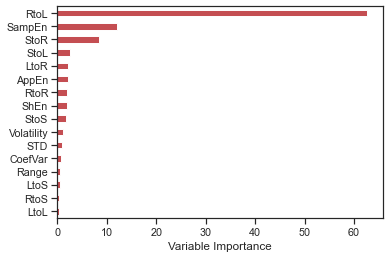

roc_auc_score 0.9925123448244035


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


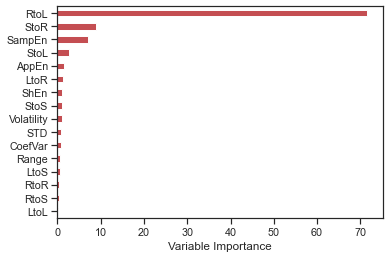

roc_auc_score 0.8778114402553362


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


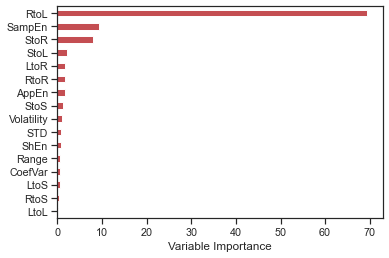

roc_auc_score 0.9984972677595628


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


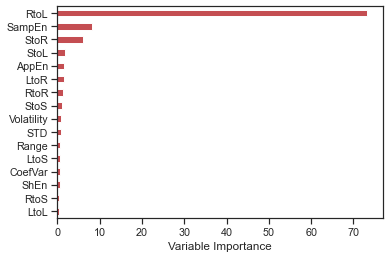

roc_auc_score 0.9717144866401612


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


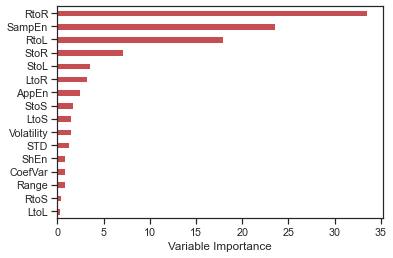

roc_auc_score 0.9957717988106284


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


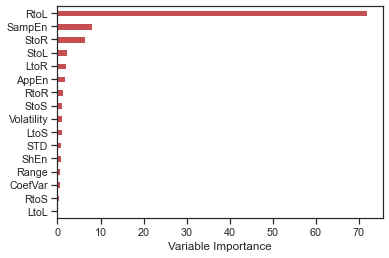

roc_auc_score 0.9359267603043608


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


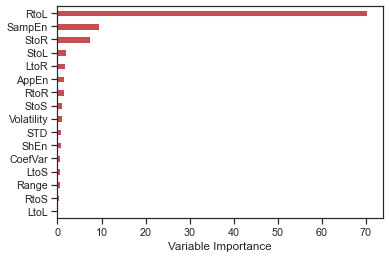

roc_auc_score 0.9579770861833106


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


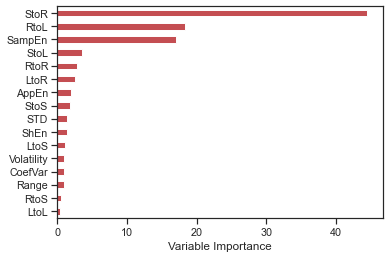

roc_auc_score 0.9647449662110464


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


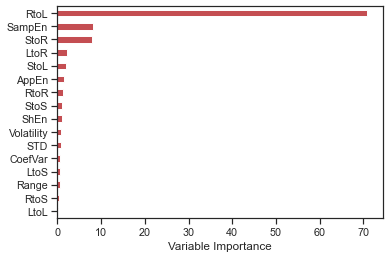

ROC_AUC not able to be calculated for subject 07162


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


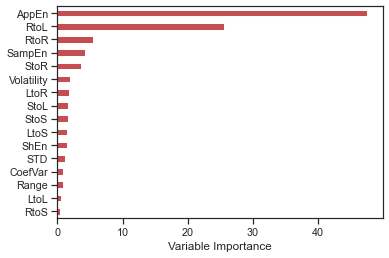

ROC_AUC not able to be calculated for subject 07859


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


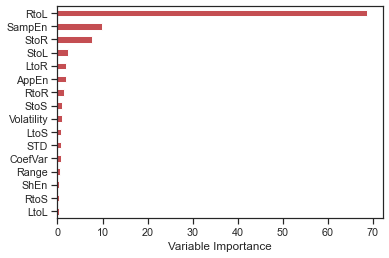

roc_auc_score 0.9989051184997939


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


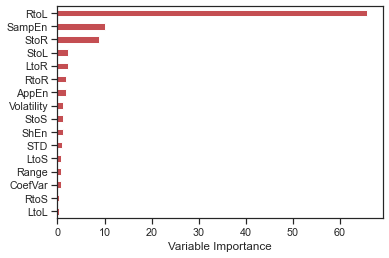

roc_auc_score 0.9980500264772763


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


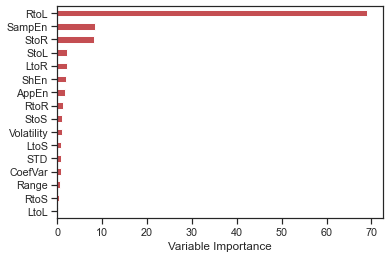

roc_auc_score 0.9997008398643807


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


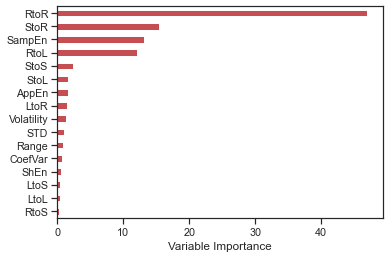

roc_auc_score 0.9613908099871058


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


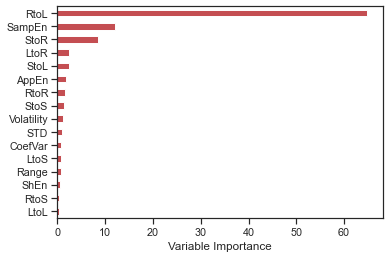

roc_auc_score 0.9798340064970743


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


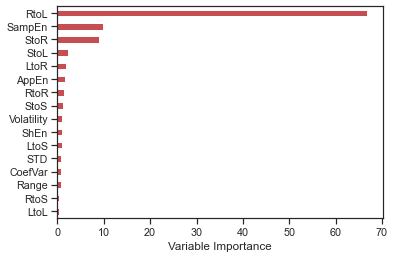

roc_auc_score 0.99888956680903


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


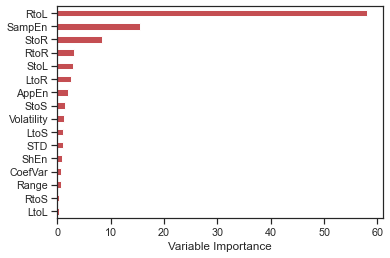

roc_auc_score 0.9999498207885305


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


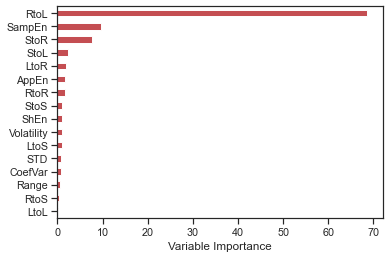

roc_auc_score 0.9999804048543708
---Run time is 69.4407753000014 seconds ---

Accuracy of each fold: 
 [0.9170480549199085, 0.9574036511156186, 0.9949622166246851, 0.9214628297362111, 0.9952978056426333, 0.9517241379310345, 0.7814105558150397, 0.9972770592239619, 0.9342369477911646, 0.9696802646085998, 0.9818511796733213, 0.9913854989231874, 0.8480725623582767, 0.9592356687898089, 0.49916736053288924, 0.9893664155959238, 0.9890335846470185, 0.9878822850548182, 0.7459847844463229, 0.8988455195162177, 0.9961505560307955, 0.9968612680477087, 0.9978858350951374]

Avg accuracy : 
0.9261837409617514

Std of accuracy : 
0.11346268957956605


In [77]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# check xgboost version
import xgboost
import xgboost as xgb
from xgboost import XGBClassifier
print(xgboost.__version__)
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)#, random_state=1)
# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')
    
from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]

    
    model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    plt.show()
    #plt.savefig('plot1.png')
    
    ##################################################
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    try:
        print("roc_auc_score", roc_auc_score(y_test, pred_prob))
    except:
        print(f'ROC_AUC not able to be calculated for subject {subject}')
    # calculate the fpr and tpr for all thresholds of the classification
    #fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob)
    #roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    #import matplotlib.pyplot as plt
    #plt.title('Receiver Operating Characteristic')
    #plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([-0.05, 1])
    #plt.ylim([0, 1.05])
    #plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.show()
    ##################################################
    
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

# Reference: 

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

max_depth (int, optional (default=-1)) – Maximum tree depth for base learners, <=0 means no limit.

learning_rate (float, optional (default=0.1)) – Boosting learning rate. You can use callbacks parameter of fit method to shrink/adapt learning rate in training using reset_parameter callback. Note, that this will ignore the learning_rate argument in training.

n_estimators (int, optional (default=100)) – Number of boosted trees to fit.

eval_metric (str, callable, list or None, optional (default=None)) – If str, it should be a built-in evaluation metric to use. If callable, it should be a custom evaluation metric, see note below for more details. If list, it can be a list of built-in metrics, a list of custom evaluation metrics, or a mix of both. In either case, the metric from the model parameters will be evaluated and used as well. 
Default: ‘l2’ for LGBMRegressor, **‘logloss’ for LGBMClassifier**, ‘ndcg’ for LGBMRanker.


C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617597	valid_0's binary_logloss: 0.571532
[2]	training's binary_logloss: 0.5563	valid_0's binary_logloss: 0.520929
[3]	training's binary_logloss: 0.504198	valid_0's binary_logloss: 0.478506
[4]	training's binary_logloss: 0.45946	valid_0's binary_logloss: 0.443006
[5]	training's binary_logloss: 0.420656	valid_0's binary_logloss: 0.41289
[6]	training's binary_logloss: 0.386916	valid_0's binary_logloss: 0.386706
[7]	training's binary_logloss: 0.357019	valid_0's binary_logloss: 0.364204
[8]	training's binary_logloss: 0.330772	valid_0's binary_logloss: 0.34522
[9]	training's binary_logloss: 0.307476	valid_0's binary_logloss: 0.327816
[10]	training's binary_logloss: 0.286637	valid_0's binary_logloss: 0.3145
[11]	training's binary_logloss: 0.268323	valid_0's binary_logloss: 0.301485
[12]	training's binary_logloss: 0.252	valid_0's binary_logloss: 0.29111
[13]	training's binary_logloss: 0.237222	valid_0's binary_logloss: 0.280767
[14]	training's binary_logloss: 

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617248	valid_0's binary_logloss: 0.587873
[2]	training's binary_logloss: 0.556263	valid_0's binary_logloss: 0.531431
[3]	training's binary_logloss: 0.504576	valid_0's binary_logloss: 0.482984
[4]	training's binary_logloss: 0.460267	valid_0's binary_logloss: 0.442108
[5]	training's binary_logloss: 0.421801	valid_0's binary_logloss: 0.405952
[6]	training's binary_logloss: 0.387774	valid_0's binary_logloss: 0.374225
[7]	training's binary_logloss: 0.358195	valid_0's binary_logloss: 0.346356
[8]	training's binary_logloss: 0.332115	valid_0's binary_logloss: 0.322396
[9]	training's binary_logloss: 0.308851	valid_0's binary_logloss: 0.301409
[10]	training's binary_logloss: 0.288519	valid_0's binary_logloss: 0.282419
[11]	training's binary_logloss: 0.270446	valid_0's binary_logloss: 0.265886
[12]	training's binary_logloss: 0.254215	valid_0's binary_logloss: 0.251532
[13]	training's binary_logloss: 0.239435	valid_0's binary_logloss: 0.238093
[14]	training's binar

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618265	valid_0's binary_logloss: 0.555405
[2]	training's binary_logloss: 0.557677	valid_0's binary_logloss: 0.493429
[3]	training's binary_logloss: 0.506162	valid_0's binary_logloss: 0.440105
[4]	training's binary_logloss: 0.462207	valid_0's binary_logloss: 0.394787
[5]	training's binary_logloss: 0.424053	valid_0's binary_logloss: 0.354719
[6]	training's binary_logloss: 0.390256	valid_0's binary_logloss: 0.319557
[7]	training's binary_logloss: 0.360892	valid_0's binary_logloss: 0.28853
[8]	training's binary_logloss: 0.335045	valid_0's binary_logloss: 0.261448
[9]	training's binary_logloss: 0.312061	valid_0's binary_logloss: 0.237024
[10]	training's binary_logloss: 0.291639	valid_0's binary_logloss: 0.215609
[11]	training's binary_logloss: 0.273459	valid_0's binary_logloss: 0.19615
[12]	training's binary_logloss: 0.257298	valid_0's binary_logloss: 0.17865
[13]	training's binary_logloss: 0.242927	valid_0's binary_logloss: 0.162949
[14]	training's binary_l

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.616943	valid_0's binary_logloss: 0.58028
[2]	training's binary_logloss: 0.555335	valid_0's binary_logloss: 0.536698
[3]	training's binary_logloss: 0.502988	valid_0's binary_logloss: 0.500483
[4]	training's binary_logloss: 0.458203	valid_0's binary_logloss: 0.468467
[5]	training's binary_logloss: 0.419423	valid_0's binary_logloss: 0.440945
[6]	training's binary_logloss: 0.385778	valid_0's binary_logloss: 0.418262
[7]	training's binary_logloss: 0.356264	valid_0's binary_logloss: 0.397699
[8]	training's binary_logloss: 0.330347	valid_0's binary_logloss: 0.379013
[9]	training's binary_logloss: 0.30719	valid_0's binary_logloss: 0.363158
[10]	training's binary_logloss: 0.286844	valid_0's binary_logloss: 0.35014
[11]	training's binary_logloss: 0.268588	valid_0's binary_logloss: 0.338597
[12]	training's binary_logloss: 0.252239	valid_0's binary_logloss: 0.328054
[13]	training's binary_logloss: 0.237738	valid_0's binary_logloss: 0.319082
[14]	training's binary_l

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613764	valid_0's binary_logloss: 0.646186
[2]	training's binary_logloss: 0.553393	valid_0's binary_logloss: 0.572723
[3]	training's binary_logloss: 0.502319	valid_0's binary_logloss: 0.510828
[4]	training's binary_logloss: 0.458523	valid_0's binary_logloss: 0.457483
[5]	training's binary_logloss: 0.420138	valid_0's binary_logloss: 0.411484
[6]	training's binary_logloss: 0.386942	valid_0's binary_logloss: 0.371524
[7]	training's binary_logloss: 0.357891	valid_0's binary_logloss: 0.336375
[8]	training's binary_logloss: 0.332266	valid_0's binary_logloss: 0.305589
[9]	training's binary_logloss: 0.309598	valid_0's binary_logloss: 0.278092
[10]	training's binary_logloss: 0.289519	valid_0's binary_logloss: 0.25372
[11]	training's binary_logloss: 0.271548	valid_0's binary_logloss: 0.232137
[12]	training's binary_logloss: 0.255525	valid_0's binary_logloss: 0.212864
[13]	training's binary_logloss: 0.241252	valid_0's binary_logloss: 0.1952
[14]	training's binary_l

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618353	valid_0's binary_logloss: 0.583267
[2]	training's binary_logloss: 0.557267	valid_0's binary_logloss: 0.533808
[3]	training's binary_logloss: 0.50554	valid_0's binary_logloss: 0.489509
[4]	training's binary_logloss: 0.460581	valid_0's binary_logloss: 0.448027
[5]	training's binary_logloss: 0.421821	valid_0's binary_logloss: 0.412452
[6]	training's binary_logloss: 0.388135	valid_0's binary_logloss: 0.381694
[7]	training's binary_logloss: 0.358623	valid_0's binary_logloss: 0.354944
[8]	training's binary_logloss: 0.332524	valid_0's binary_logloss: 0.331512
[9]	training's binary_logloss: 0.309578	valid_0's binary_logloss: 0.310871
[10]	training's binary_logloss: 0.289038	valid_0's binary_logloss: 0.29268
[11]	training's binary_logloss: 0.270665	valid_0's binary_logloss: 0.276689
[12]	training's binary_logloss: 0.254303	valid_0's binary_logloss: 0.266227
[13]	training's binary_logloss: 0.239831	valid_0's binary_logloss: 0.253368
[14]	training's binary_

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.610619	valid_0's binary_logloss: 0.704048
[2]	training's binary_logloss: 0.549116	valid_0's binary_logloss: 0.656698
[3]	training's binary_logloss: 0.496929	valid_0's binary_logloss: 0.618934
[4]	training's binary_logloss: 0.452411	valid_0's binary_logloss: 0.584509
[5]	training's binary_logloss: 0.413568	valid_0's binary_logloss: 0.555081
[6]	training's binary_logloss: 0.379894	valid_0's binary_logloss: 0.530632
[7]	training's binary_logloss: 0.350424	valid_0's binary_logloss: 0.509618
[8]	training's binary_logloss: 0.324205	valid_0's binary_logloss: 0.493075
[9]	training's binary_logloss: 0.301031	valid_0's binary_logloss: 0.478847
[10]	training's binary_logloss: 0.280522	valid_0's binary_logloss: 0.46752
[11]	training's binary_logloss: 0.262244	valid_0's binary_logloss: 0.457162
[12]	training's binary_logloss: 0.245755	valid_0's binary_logloss: 0.448984
[13]	training's binary_logloss: 0.231232	valid_0's binary_logloss: 0.442554
[14]	training's binary

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618076	valid_0's binary_logloss: 0.552495
[2]	training's binary_logloss: 0.557406	valid_0's binary_logloss: 0.490589
[3]	training's binary_logloss: 0.505985	valid_0's binary_logloss: 0.437823
[4]	training's binary_logloss: 0.461758	valid_0's binary_logloss: 0.392093
[5]	training's binary_logloss: 0.423572	valid_0's binary_logloss: 0.352256
[6]	training's binary_logloss: 0.390061	valid_0's binary_logloss: 0.317586
[7]	training's binary_logloss: 0.360484	valid_0's binary_logloss: 0.286785
[8]	training's binary_logloss: 0.334667	valid_0's binary_logloss: 0.259855
[9]	training's binary_logloss: 0.311539	valid_0's binary_logloss: 0.235838
[10]	training's binary_logloss: 0.291252	valid_0's binary_logloss: 0.214085
[11]	training's binary_logloss: 0.273032	valid_0's binary_logloss: 0.194739
[12]	training's binary_logloss: 0.25677	valid_0's binary_logloss: 0.177414
[13]	training's binary_logloss: 0.242411	valid_0's binary_logloss: 0.161805
[14]	training's binary

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61248	valid_0's binary_logloss: 0.668232
[2]	training's binary_logloss: 0.551506	valid_0's binary_logloss: 0.605133
[3]	training's binary_logloss: 0.499862	valid_0's binary_logloss: 0.55228
[4]	training's binary_logloss: 0.455664	valid_0's binary_logloss: 0.506664
[5]	training's binary_logloss: 0.417567	valid_0's binary_logloss: 0.46857
[6]	training's binary_logloss: 0.38384	valid_0's binary_logloss: 0.435413
[7]	training's binary_logloss: 0.354425	valid_0's binary_logloss: 0.40674
[8]	training's binary_logloss: 0.32836	valid_0's binary_logloss: 0.381793
[9]	training's binary_logloss: 0.305377	valid_0's binary_logloss: 0.360788
[10]	training's binary_logloss: 0.284878	valid_0's binary_logloss: 0.341503
[11]	training's binary_logloss: 0.266747	valid_0's binary_logloss: 0.324438
[12]	training's binary_logloss: 0.250477	valid_0's binary_logloss: 0.309338
[13]	training's binary_logloss: 0.235831	valid_0's binary_logloss: 0.296
[14]	training's binary_logloss

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618799	valid_0's binary_logloss: 0.568675
[2]	training's binary_logloss: 0.558224	valid_0's binary_logloss: 0.514158
[3]	training's binary_logloss: 0.50693	valid_0's binary_logloss: 0.467605
[4]	training's binary_logloss: 0.462115	valid_0's binary_logloss: 0.426251
[5]	training's binary_logloss: 0.423426	valid_0's binary_logloss: 0.390247
[6]	training's binary_logloss: 0.38974	valid_0's binary_logloss: 0.359058
[7]	training's binary_logloss: 0.3604	valid_0's binary_logloss: 0.331943
[8]	training's binary_logloss: 0.334399	valid_0's binary_logloss: 0.307509
[9]	training's binary_logloss: 0.3114	valid_0's binary_logloss: 0.286149
[10]	training's binary_logloss: 0.291103	valid_0's binary_logloss: 0.266439
[11]	training's binary_logloss: 0.272872	valid_0's binary_logloss: 0.249106
[12]	training's binary_logloss: 0.256871	valid_0's binary_logloss: 0.233925
[13]	training's binary_logloss: 0.242224	valid_0's binary_logloss: 0.220487
[14]	training's binary_logl

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.608878	valid_0's binary_logloss: 0.742775
[2]	training's binary_logloss: 0.548732	valid_0's binary_logloss: 0.656814
[3]	training's binary_logloss: 0.497814	valid_0's binary_logloss: 0.585461
[4]	training's binary_logloss: 0.454211	valid_0's binary_logloss: 0.524876
[5]	training's binary_logloss: 0.416321	valid_0's binary_logloss: 0.473364
[6]	training's binary_logloss: 0.383272	valid_0's binary_logloss: 0.429107
[7]	training's binary_logloss: 0.354357	valid_0's binary_logloss: 0.390397
[8]	training's binary_logloss: 0.328839	valid_0's binary_logloss: 0.356583
[9]	training's binary_logloss: 0.30641	valid_0's binary_logloss: 0.32682
[10]	training's binary_logloss: 0.286369	valid_0's binary_logloss: 0.300749
[11]	training's binary_logloss: 0.268565	valid_0's binary_logloss: 0.277583
[12]	training's binary_logloss: 0.252808	valid_0's binary_logloss: 0.25704
[13]	training's binary_logloss: 0.238457	valid_0's binary_logloss: 0.238635
[14]	training's binary_l

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617827	valid_0's binary_logloss: 0.554111
[2]	training's binary_logloss: 0.557043	valid_0's binary_logloss: 0.493993
[3]	training's binary_logloss: 0.505612	valid_0's binary_logloss: 0.442945
[4]	training's binary_logloss: 0.461382	valid_0's binary_logloss: 0.398479
[5]	training's binary_logloss: 0.423059	valid_0's binary_logloss: 0.359808
[6]	training's binary_logloss: 0.38924	valid_0's binary_logloss: 0.325937
[7]	training's binary_logloss: 0.359813	valid_0's binary_logloss: 0.296081
[8]	training's binary_logloss: 0.333924	valid_0's binary_logloss: 0.269918
[9]	training's binary_logloss: 0.310855	valid_0's binary_logloss: 0.246857
[10]	training's binary_logloss: 0.290544	valid_0's binary_logloss: 0.226154
[11]	training's binary_logloss: 0.272405	valid_0's binary_logloss: 0.207781
[12]	training's binary_logloss: 0.256204	valid_0's binary_logloss: 0.191181
[13]	training's binary_logloss: 0.241798	valid_0's binary_logloss: 0.176195
[14]	training's binary

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614373	valid_0's binary_logloss: 0.640206
[2]	training's binary_logloss: 0.553245	valid_0's binary_logloss: 0.593804
[3]	training's binary_logloss: 0.501602	valid_0's binary_logloss: 0.554388
[4]	training's binary_logloss: 0.457296	valid_0's binary_logloss: 0.521932
[5]	training's binary_logloss: 0.417857	valid_0's binary_logloss: 0.494993
[6]	training's binary_logloss: 0.383473	valid_0's binary_logloss: 0.473704
[7]	training's binary_logloss: 0.353983	valid_0's binary_logloss: 0.452994
[8]	training's binary_logloss: 0.327506	valid_0's binary_logloss: 0.436049
[9]	training's binary_logloss: 0.304647	valid_0's binary_logloss: 0.422159
[10]	training's binary_logloss: 0.283769	valid_0's binary_logloss: 0.410414
[11]	training's binary_logloss: 0.265351	valid_0's binary_logloss: 0.397518
[12]	training's binary_logloss: 0.248832	valid_0's binary_logloss: 0.390865
[13]	training's binary_logloss: 0.234396	valid_0's binary_logloss: 0.382075
[14]	training's binar

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.610824	valid_0's binary_logloss: 0.748628
[2]	training's binary_logloss: 0.550638	valid_0's binary_logloss: 0.670913
[3]	training's binary_logloss: 0.499661	valid_0's binary_logloss: 0.606707
[4]	training's binary_logloss: 0.455916	valid_0's binary_logloss: 0.552723
[5]	training's binary_logloss: 0.417729	valid_0's binary_logloss: 0.503157
[6]	training's binary_logloss: 0.384462	valid_0's binary_logloss: 0.462201
[7]	training's binary_logloss: 0.355446	valid_0's binary_logloss: 0.424874
[8]	training's binary_logloss: 0.329874	valid_0's binary_logloss: 0.395611
[9]	training's binary_logloss: 0.30736	valid_0's binary_logloss: 0.367685
[10]	training's binary_logloss: 0.287301	valid_0's binary_logloss: 0.341027
[11]	training's binary_logloss: 0.269395	valid_0's binary_logloss: 0.319169
[12]	training's binary_logloss: 0.253543	valid_0's binary_logloss: 0.298557
[13]	training's binary_logloss: 0.239078	valid_0's binary_logloss: 0.281288
[14]	training's binary

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.604784	valid_0's binary_logloss: 0.87454
[2]	training's binary_logloss: 0.542536	valid_0's binary_logloss: 0.885234
[3]	training's binary_logloss: 0.489961	valid_0's binary_logloss: 0.900188
[4]	training's binary_logloss: 0.444772	valid_0's binary_logloss: 0.910695
[5]	training's binary_logloss: 0.405789	valid_0's binary_logloss: 0.928466
[6]	training's binary_logloss: 0.371951	valid_0's binary_logloss: 0.944028
[7]	training's binary_logloss: 0.342279	valid_0's binary_logloss: 0.961301
[8]	training's binary_logloss: 0.315971	valid_0's binary_logloss: 0.975812
[9]	training's binary_logloss: 0.292772	valid_0's binary_logloss: 0.991902
[10]	training's binary_logloss: 0.272311	valid_0's binary_logloss: 1.01034
[11]	training's binary_logloss: 0.253914	valid_0's binary_logloss: 1.03452
[12]	training's binary_logloss: 0.237649	valid_0's binary_logloss: 1.04013
[13]	training's binary_logloss: 0.222681	valid_0's binary_logloss: 1.06202
[14]	training's binary_log

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61245	valid_0's binary_logloss: 0.668609
[2]	training's binary_logloss: 0.552113	valid_0's binary_logloss: 0.596645
[3]	training's binary_logloss: 0.500963	valid_0's binary_logloss: 0.536837
[4]	training's binary_logloss: 0.457236	valid_0's binary_logloss: 0.485023
[5]	training's binary_logloss: 0.418977	valid_0's binary_logloss: 0.440385
[6]	training's binary_logloss: 0.385575	valid_0's binary_logloss: 0.401463
[7]	training's binary_logloss: 0.356408	valid_0's binary_logloss: 0.367431
[8]	training's binary_logloss: 0.330846	valid_0's binary_logloss: 0.337121
[9]	training's binary_logloss: 0.308321	valid_0's binary_logloss: 0.310266
[10]	training's binary_logloss: 0.288164	valid_0's binary_logloss: 0.286117
[11]	training's binary_logloss: 0.270271	valid_0's binary_logloss: 0.2651
[12]	training's binary_logloss: 0.254403	valid_0's binary_logloss: 0.245819
[13]	training's binary_logloss: 0.240034	valid_0's binary_logloss: 0.228608
[14]	training's binary_l

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617056	valid_0's binary_logloss: 0.571383
[2]	training's binary_logloss: 0.556357	valid_0's binary_logloss: 0.509616
[3]	training's binary_logloss: 0.50488	valid_0's binary_logloss: 0.456851
[4]	training's binary_logloss: 0.460999	valid_0's binary_logloss: 0.41199
[5]	training's binary_logloss: 0.422256	valid_0's binary_logloss: 0.372513
[6]	training's binary_logloss: 0.38865	valid_0's binary_logloss: 0.33785
[7]	training's binary_logloss: 0.35923	valid_0's binary_logloss: 0.30711
[8]	training's binary_logloss: 0.333478	valid_0's binary_logloss: 0.280143
[9]	training's binary_logloss: 0.310546	valid_0's binary_logloss: 0.255865
[10]	training's binary_logloss: 0.290191	valid_0's binary_logloss: 0.235024
[11]	training's binary_logloss: 0.272066	valid_0's binary_logloss: 0.216073
[12]	training's binary_logloss: 0.255923	valid_0's binary_logloss: 0.198746
[13]	training's binary_logloss: 0.241414	valid_0's binary_logloss: 0.183424
[14]	training's binary_logl

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612885	valid_0's binary_logloss: 0.675965
[2]	training's binary_logloss: 0.552651	valid_0's binary_logloss: 0.600594
[3]	training's binary_logloss: 0.501718	valid_0's binary_logloss: 0.53659
[4]	training's binary_logloss: 0.458032	valid_0's binary_logloss: 0.483433
[5]	training's binary_logloss: 0.419801	valid_0's binary_logloss: 0.43532
[6]	training's binary_logloss: 0.386509	valid_0's binary_logloss: 0.393404
[7]	training's binary_logloss: 0.357398	valid_0's binary_logloss: 0.357156
[8]	training's binary_logloss: 0.331613	valid_0's binary_logloss: 0.324902
[9]	training's binary_logloss: 0.309103	valid_0's binary_logloss: 0.298516
[10]	training's binary_logloss: 0.288745	valid_0's binary_logloss: 0.273002
[11]	training's binary_logloss: 0.270666	valid_0's binary_logloss: 0.250145
[12]	training's binary_logloss: 0.254713	valid_0's binary_logloss: 0.231927
[13]	training's binary_logloss: 0.240512	valid_0's binary_logloss: 0.214127
[14]	training's binary_

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.615178	valid_0's binary_logloss: 0.626065
[2]	training's binary_logloss: 0.552716	valid_0's binary_logloss: 0.601615
[3]	training's binary_logloss: 0.499816	valid_0's binary_logloss: 0.585855
[4]	training's binary_logloss: 0.454589	valid_0's binary_logloss: 0.57047
[5]	training's binary_logloss: 0.41538	valid_0's binary_logloss: 0.55877
[6]	training's binary_logloss: 0.38064	valid_0's binary_logloss: 0.547482
[7]	training's binary_logloss: 0.350184	valid_0's binary_logloss: 0.540786
[8]	training's binary_logloss: 0.323379	valid_0's binary_logloss: 0.53399
[9]	training's binary_logloss: 0.29973	valid_0's binary_logloss: 0.532177
[10]	training's binary_logloss: 0.278693	valid_0's binary_logloss: 0.529115
[11]	training's binary_logloss: 0.259799	valid_0's binary_logloss: 0.531059
[12]	training's binary_logloss: 0.243016	valid_0's binary_logloss: 0.531513
[13]	training's binary_logloss: 0.227957	valid_0's binary_logloss: 0.535923
[14]	training's binary_logl

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.616867	valid_0's binary_logloss: 0.591971
[2]	training's binary_logloss: 0.556013	valid_0's binary_logloss: 0.538148
[3]	training's binary_logloss: 0.504479	valid_0's binary_logloss: 0.490647
[4]	training's binary_logloss: 0.460173	valid_0's binary_logloss: 0.453415
[5]	training's binary_logloss: 0.421418	valid_0's binary_logloss: 0.420723
[6]	training's binary_logloss: 0.387898	valid_0's binary_logloss: 0.392086
[7]	training's binary_logloss: 0.358334	valid_0's binary_logloss: 0.362418
[8]	training's binary_logloss: 0.332497	valid_0's binary_logloss: 0.336261
[9]	training's binary_logloss: 0.309427	valid_0's binary_logloss: 0.314898
[10]	training's binary_logloss: 0.289009	valid_0's binary_logloss: 0.293961
[11]	training's binary_logloss: 0.270922	valid_0's binary_logloss: 0.280081
[12]	training's binary_logloss: 0.254788	valid_0's binary_logloss: 0.270175
[13]	training's binary_logloss: 0.240259	valid_0's binary_logloss: 0.259909
[14]	training's binar

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611781	valid_0's binary_logloss: 0.682178
[2]	training's binary_logloss: 0.551662	valid_0's binary_logloss: 0.606457
[3]	training's binary_logloss: 0.500795	valid_0's binary_logloss: 0.54178
[4]	training's binary_logloss: 0.457018	valid_0's binary_logloss: 0.485586
[5]	training's binary_logloss: 0.418841	valid_0's binary_logloss: 0.43816
[6]	training's binary_logloss: 0.385764	valid_0's binary_logloss: 0.3967
[7]	training's binary_logloss: 0.356736	valid_0's binary_logloss: 0.360861
[8]	training's binary_logloss: 0.331321	valid_0's binary_logloss: 0.329138
[9]	training's binary_logloss: 0.30868	valid_0's binary_logloss: 0.300099
[10]	training's binary_logloss: 0.288669	valid_0's binary_logloss: 0.275521
[11]	training's binary_logloss: 0.270991	valid_0's binary_logloss: 0.253994
[12]	training's binary_logloss: 0.254997	valid_0's binary_logloss: 0.233704
[13]	training's binary_logloss: 0.240713	valid_0's binary_logloss: 0.215813
[14]	training's binary_log

C:\Users\Luke\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618032	valid_0's binary_logloss: 0.55929
[2]	training's binary_logloss: 0.557325	valid_0's binary_logloss: 0.497787
[3]	training's binary_logloss: 0.5059	valid_0's binary_logloss: 0.445243
[4]	training's binary_logloss: 0.461426	valid_0's binary_logloss: 0.399861
[5]	training's binary_logloss: 0.423075	valid_0's binary_logloss: 0.360691
[6]	training's binary_logloss: 0.389604	valid_0's binary_logloss: 0.326627
[7]	training's binary_logloss: 0.360485	valid_0's binary_logloss: 0.296682
[8]	training's binary_logloss: 0.334436	valid_0's binary_logloss: 0.269935
[9]	training's binary_logloss: 0.311332	valid_0's binary_logloss: 0.246241
[10]	training's binary_logloss: 0.290968	valid_0's binary_logloss: 0.225075
[11]	training's binary_logloss: 0.27289	valid_0's binary_logloss: 0.206139
[12]	training's binary_logloss: 0.256596	valid_0's binary_logloss: 0.189016
[13]	training's binary_logloss: 0.242351	valid_0's binary_logloss: 0.173794
[14]	training's binary_lo

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612015	valid_0's binary_logloss: 0.675878
[2]	training's binary_logloss: 0.551805	valid_0's binary_logloss: 0.599843
[3]	training's binary_logloss: 0.50082	valid_0's binary_logloss: 0.535537
[4]	training's binary_logloss: 0.456785	valid_0's binary_logloss: 0.48127
[5]	training's binary_logloss: 0.418722	valid_0's binary_logloss: 0.433837
[6]	training's binary_logloss: 0.385629	valid_0's binary_logloss: 0.393274
[7]	training's binary_logloss: 0.356639	valid_0's binary_logloss: 0.357307
[8]	training's binary_logloss: 0.331133	valid_0's binary_logloss: 0.325367
[9]	training's binary_logloss: 0.30869	valid_0's binary_logloss: 0.297574
[10]	training's binary_logloss: 0.288727	valid_0's binary_logloss: 0.272724
[11]	training's binary_logloss: 0.270793	valid_0's binary_logloss: 0.250522
[12]	training's binary_logloss: 0.254886	valid_0's binary_logloss: 0.230661
[13]	training's binary_logloss: 0.240559	valid_0's binary_logloss: 0.212936
[14]	training's binary_l

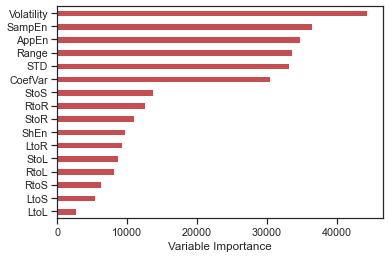

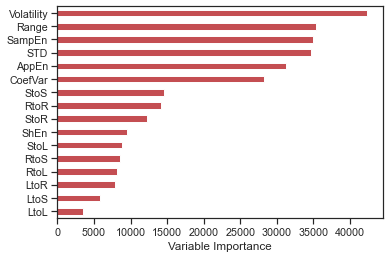

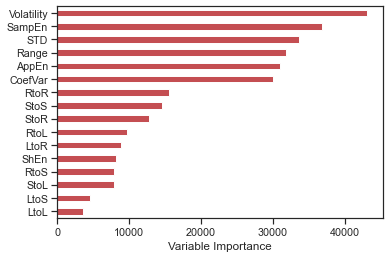

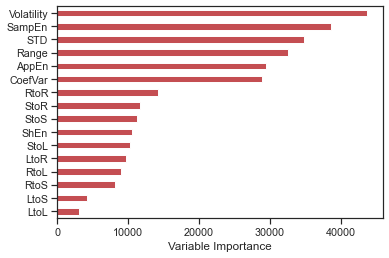

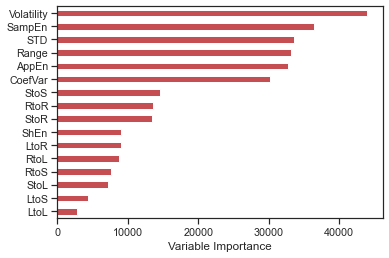

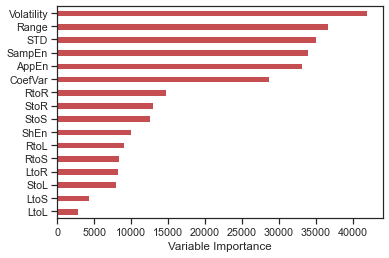

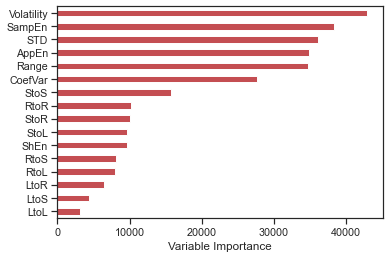

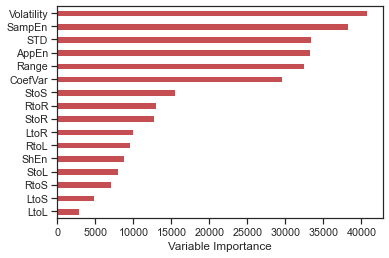

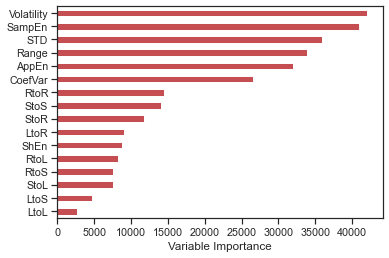

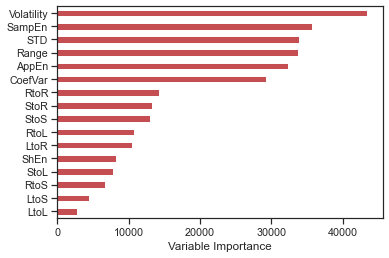

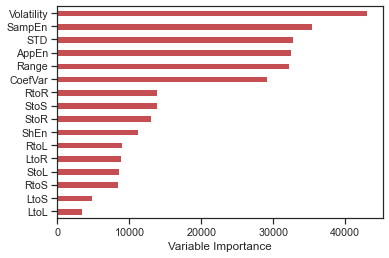

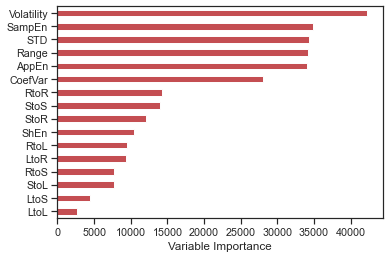

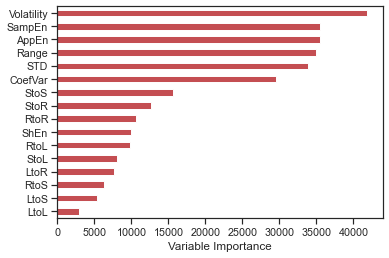

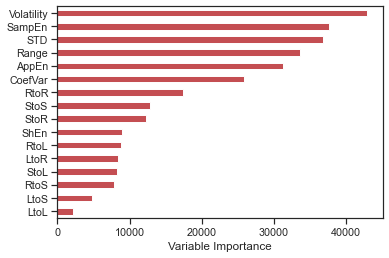

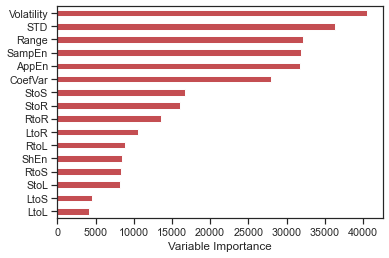

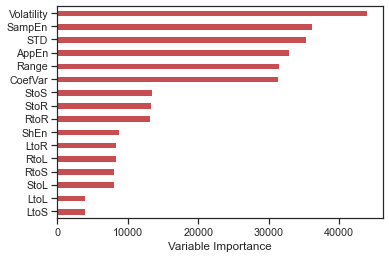

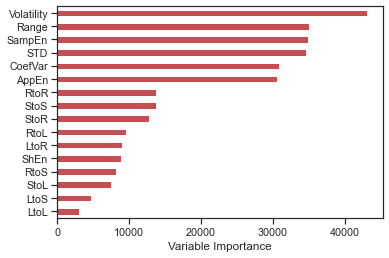

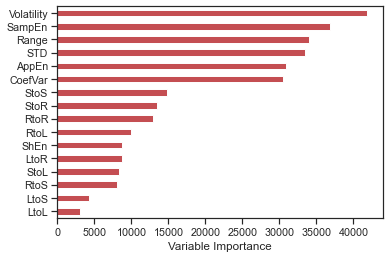

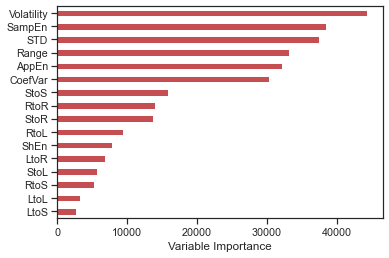

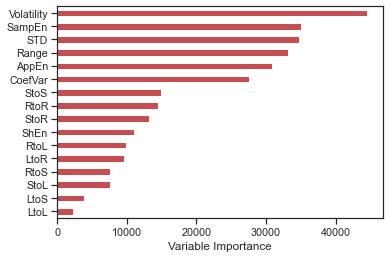

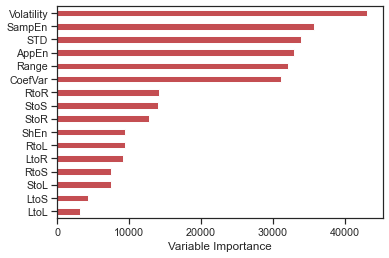

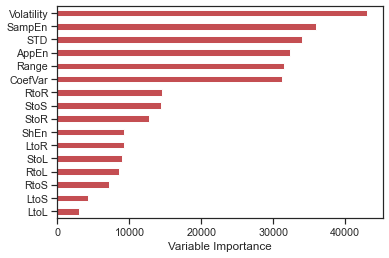

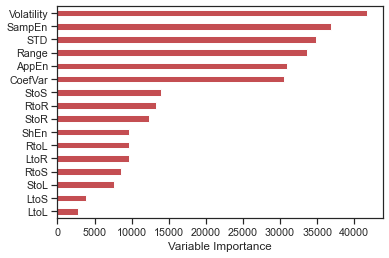

In [78]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)
model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];

x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']


for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]

    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [9]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))

[[198  14]
 [  9 348]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       212
           1       0.96      0.97      0.97       357

    accuracy                           0.96       569
   macro avg       0.96      0.95      0.96       569
weighted avg       0.96      0.96      0.96       569



# CatBoosting

In [66]:
# https://catboost.ai/en/docs/concepts/python-quickstart
import catboost as cb
from catboost import CatBoostClassifier


print ('catboost version', cb.__version__)

catboost version 1.0.6


C:\Users\Luke\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


---Run time is 12.616163400001824 seconds ---

Accuracy of each fold: 
 [0.9136155606407322, 0.9557809330628804, 0.9968513853904282, 0.9274580335731415, 0.9958202716823407, 0.9415821501014199, 0.8150397010742644, 0.9972770592239619, 0.9317269076305221, 0.9669239250275634, 0.9823049001814882, 0.9885139985642498, 0.8263038548752835, 0.9777070063694268, 0.4013322231473772, 0.9933540097474524, 0.9890335846470185, 0.986728216964801, 0.7117497886728656, 0.9725123694337549, 0.9957228400342173, 0.9956057752667922, 0.9970401691331924]

Avg accuracy : 
0.9243471593237033

Std of accuracy : 
0.13190938897709428


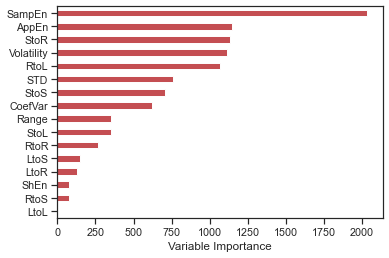

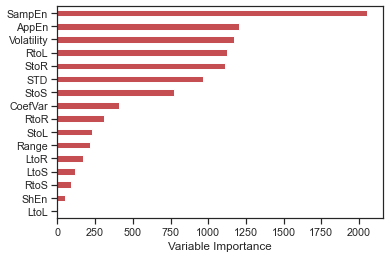

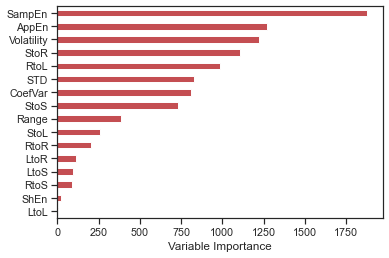

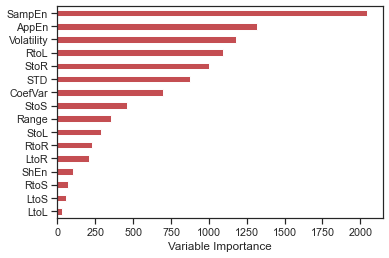

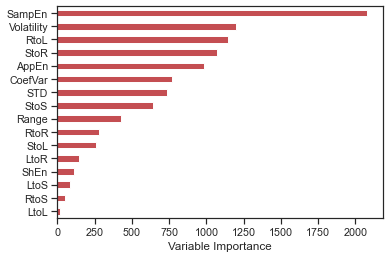

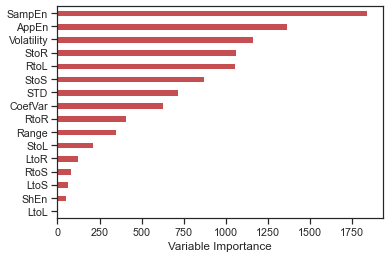

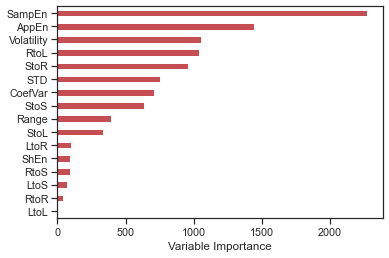

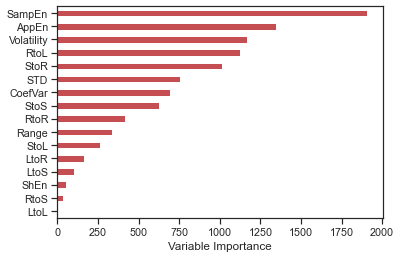

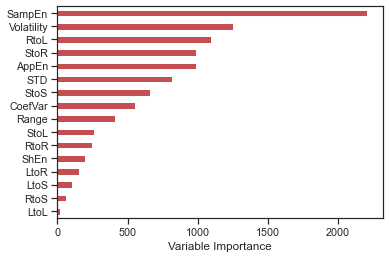

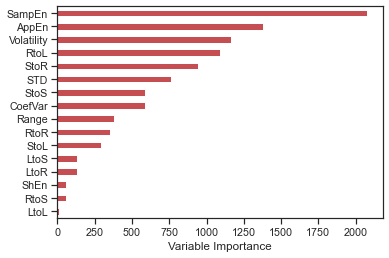

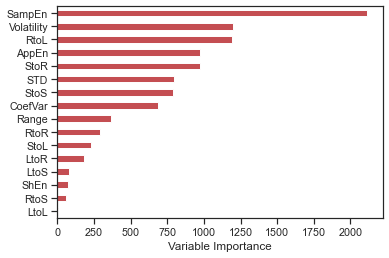

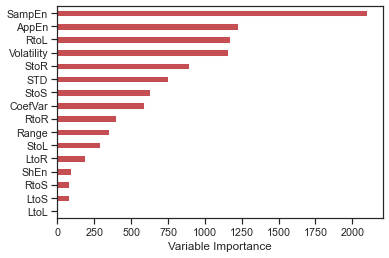

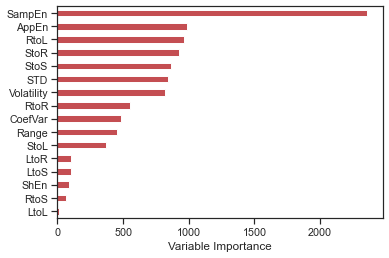

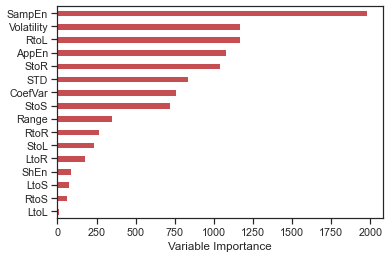

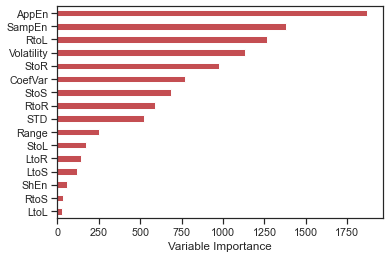

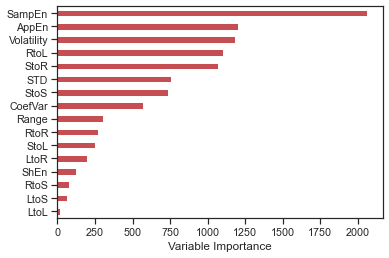

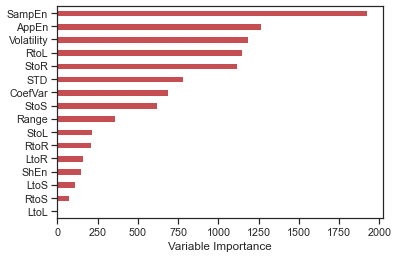

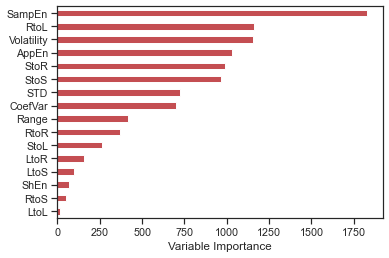

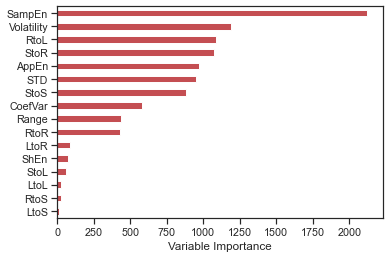

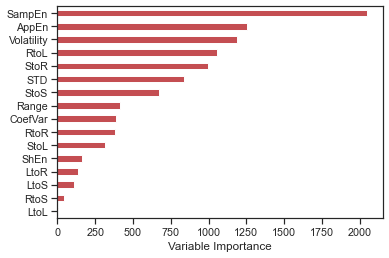

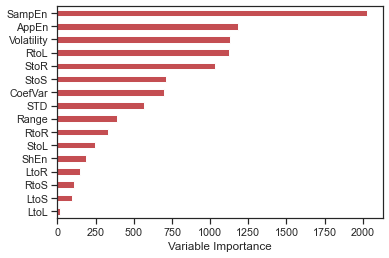

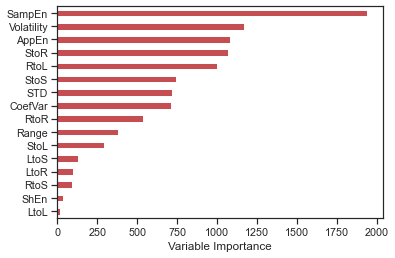

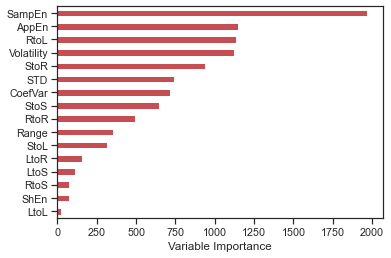

In [79]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
 
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]
    
    # Create CatBoost model
    model = CatBoostClassifier(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                           loss_function='Logloss')
    # train the model
    model.fit(X_train, y_train, verbose=False)
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [59]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))

[[199  13]
 [  5 352]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       212
           1       0.96      0.99      0.98       357

    accuracy                           0.97       569
   macro avg       0.97      0.96      0.97       569
weighted avg       0.97      0.97      0.97       569



# Please neglect: The following are some codes to be developed

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html